## RAVDESS Dataset

### "The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

This portion of the RAVDESS contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

1. Audio-only (03)
2. Speech (01)
3. Fearful (06)
4. Normal intensity (01)
5. Statement "dogs" (02)
6. 1st Repetition (01)
7. 12th Actor (12)
Female, as the actor ID number is even.

In [71]:
# load dataset from archive folder (Actor_01, Actor_02...), .wav file
import os
import pandas as pd

def load_dataset(archive_path):
    data = []
    for actor_folder in os.listdir(archive_path):
        actor_path = os.path.join(archive_path, actor_folder)
        if os.path.isdir(actor_path):
            for file_name in os.listdir(actor_path):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(actor_path, file_name)
                    # Extract data from file name
                    parts = file_name.split('-')
                    emotion_code = parts[2]
                    emotion_map = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
                    emotion = emotion_map.get(emotion_code, 'unknown')
                    data.append({'file_path': file_path, 'emotion': emotion})
    df = pd.DataFrame(data)
    return df

In [72]:
# See dataset
df = load_dataset('archive')
print(df.head())
len(df)

                                   file_path  emotion
0  archive/Actor_11/03-01-02-02-02-01-11.wav     calm
1  archive/Actor_11/03-01-07-01-02-02-11.wav  disgust
2  archive/Actor_11/03-01-03-01-01-01-11.wav    happy
3  archive/Actor_11/03-01-06-01-01-01-11.wav  fearful
4  archive/Actor_11/03-01-03-02-02-02-11.wav    happy


1440

In [73]:
# Load CREMA-D dataset (AudioWAV folder)
def load_crema_d_dataset(crema_d_path):
    data = []
    for file_name in os.listdir(crema_d_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(crema_d_path, file_name)
            # Extract data from file name
            parts = file_name.split('_')
            emotion_code = parts[2]
            emotion_map = {'NEU': 'neutral', 'HAP': 'happy', 'SAD': 'sad', 'ANG': 'angry', 'FEA': 'fearful', 'DIS': 'disgust', 'SUR': 'surprised'}
            emotion = emotion_map.get(emotion_code, 'unknown')
            data.append({'file_path': file_path, 'emotion': emotion})
    df = pd.DataFrame(data)
    return df

In [74]:
# Put CREMA-D dataset into dataframe
crema_d_df = load_crema_d_dataset('AudioWAV')
print(crema_d_df.head())
len(crema_d_df)

                      file_path  emotion
0  AudioWAV/1013_DFA_SAD_XX.wav      sad
1  AudioWAV/1091_WSI_ANG_XX.wav    angry
2  AudioWAV/1009_IOM_HAP_XX.wav    happy
3  AudioWAV/1053_MTI_DIS_XX.wav  disgust
4  AudioWAV/1033_IWW_DIS_XX.wav  disgust


7442

In [75]:
# Combine both datasets
combined_df = pd.concat([df, crema_d_df], ignore_index=True)
print(combined_df.head())
len(combined_df)

                                   file_path  emotion
0  archive/Actor_11/03-01-02-02-02-01-11.wav     calm
1  archive/Actor_11/03-01-07-01-02-02-11.wav  disgust
2  archive/Actor_11/03-01-03-01-01-01-11.wav    happy
3  archive/Actor_11/03-01-06-01-01-01-11.wav  fearful
4  archive/Actor_11/03-01-03-02-02-02-11.wav    happy


8882

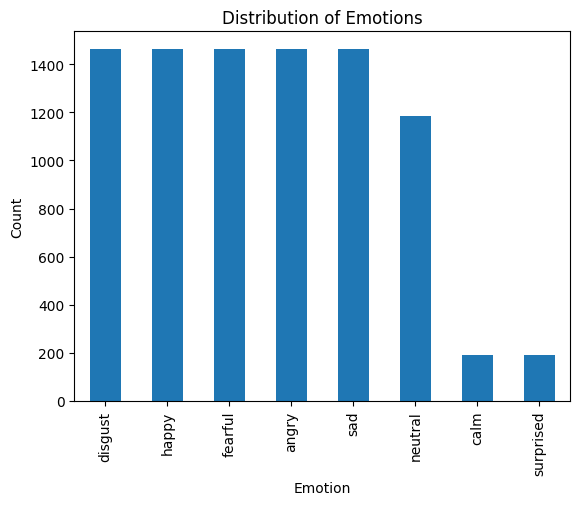

In [76]:
# Distribution of emotions graph
# import matplotlib.pyplot as plt
# emotion_counts = df['emotion'].value_counts()
# emotion_counts.plot(kind='bar')
# plt.xlabel('Emotion')
# plt.ylabel('Count')
# plt.title('Distribution of Emotions')
# plt.show()
import matplotlib.pyplot as plt
emotion_counts = combined_df['emotion'].value_counts()
emotion_counts.plot(kind='bar')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions')
plt.show()

In [77]:
# Combine neutral and calm into neutral for BOTH datasets
df['emotion'] = df['emotion'].replace({'calm': 'neutral'})
combined_df['emotion'] = combined_df['emotion'].replace({'calm': 'neutral'})
print(combined_df['emotion'].value_counts())

emotion
disgust      1463
happy        1463
fearful      1463
sad          1463
angry        1463
neutral      1375
surprised     192
Name: count, dtype: int64


In [78]:
import numpy as np
import librosa

SR = 16000  # Sample rate
DURATION = 3.0  # Duration in seconds
#Start
START = 1.0  # Start time in seconds
START_SAMPLE = int(SR * START)  # Start sample index
SAMPLES = int(SR * DURATION)  # Total samples per audio file

In [79]:
# Get 1-4 seconds from audio file, pad with zeros if less than 4 seconds

def load_audio(path, sr=SR, samples=SAMPLES, start_sample=START_SAMPLE):
    y, _ = librosa.load(path, sr=sr, mono=True)
    # Trim from start_sample, then pad if needed
    y = y[start_sample:] if len(y) > start_sample else np.array([])
    if len(y) >= samples:
        y = y[:samples]
    else:
        y = np.pad(y, (0, samples - len(y)), "constant")
    return y

In [80]:
# import numpy as np

# N_MELS = 64
# N_FFT = 1024
# # HOP_LENGTH = 160
# HOP_LENGTH = 256
# # With SR=16000, DURATION=2.5s, calculate target frames
# TARGET_FRAMES = int(np.ceil((SAMPLES - N_FFT) / HOP_LENGTH)) + 1

# def waveform_to_logmel(y, sr=SR):
#     """Convert a waveform array to log-mel spectrogram."""
#     mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH, fmin=20, fmax=8000, power=2.0, window='hann', center=True)
#     # logmel = librosa.power_to_db(mel, ref=np.max)
#     logmel = np.log(mel + 1e-6)  # Use log to avoid negative infinity

#     # Enforce fixed time frames
#     frames = logmel.shape[1]
#     if frames < TARGET_FRAMES:
#         logmel = np.pad(logmel, ((0, 0), (0, TARGET_FRAMES - frames)), mode='constant')
#     elif frames > TARGET_FRAMES:
#         logmel = logmel[:, :TARGET_FRAMES]

#     # per-sample normalization
#     logmel = (logmel - logmel.mean()) / (logmel.std() + 1e-6)

#     return logmel.astype(np.float32)


# # Will optimize it better
# def wav_to_logmel(path, sr=SR):
#     """Load audio from path and convert to log-mel spectrogram."""
#     y = load_audio(path, sr=sr)
#     return waveform_to_logmel(y, sr=sr)

import numpy as np

N_MELS = 64
N_FFT = 1024
HOP_LENGTH = 256
TARGET_FRAMES = int(np.ceil((SAMPLES - N_FFT) / HOP_LENGTH)) + 1

def waveform_to_logmel(y, sr=SR):
    """Convert a waveform array to log-mel spectrogram with delta features."""
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=N_MELS, n_fft=N_FFT, 
        hop_length=HOP_LENGTH, fmin=20, fmax=8000, 
        power=2.0, window='hann', center=True
    )
    logmel = np.log(mel + 1e-6)

    # Enforce fixed time frames
    frames = logmel.shape[1]
    if frames < TARGET_FRAMES:
        logmel = np.pad(logmel, ((0, 0), (0, TARGET_FRAMES - frames)), mode='constant')
    elif frames > TARGET_FRAMES:
        logmel = logmel[:, :TARGET_FRAMES]

    # Compute delta and delta-delta features
    delta = librosa.feature.delta(logmel)
    delta2 = librosa.feature.delta(logmel, order=2)

    # Stack as 3 channels: [logmel, delta, delta2]
    features = np.stack([logmel, delta, delta2], axis=0)  # Shape: (3, N_MELS, TARGET_FRAMES)

    # Normalize each channel independently
    for i in range(3):
        features[i] = (features[i] - features[i].mean()) / (features[i].std() + 1e-6)

    return features.astype(np.float32)


def wav_to_logmel(path, sr=SR):
    """Load audio from path and convert to log-mel spectrogram with deltas."""
    y = load_audio(path, sr=sr)
    return waveform_to_logmel(y, sr=sr)

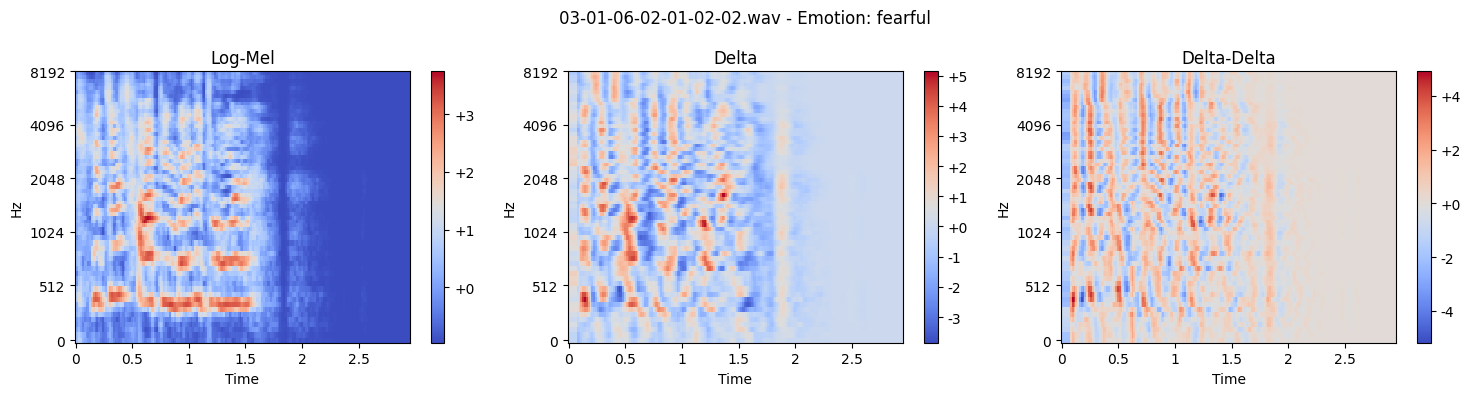

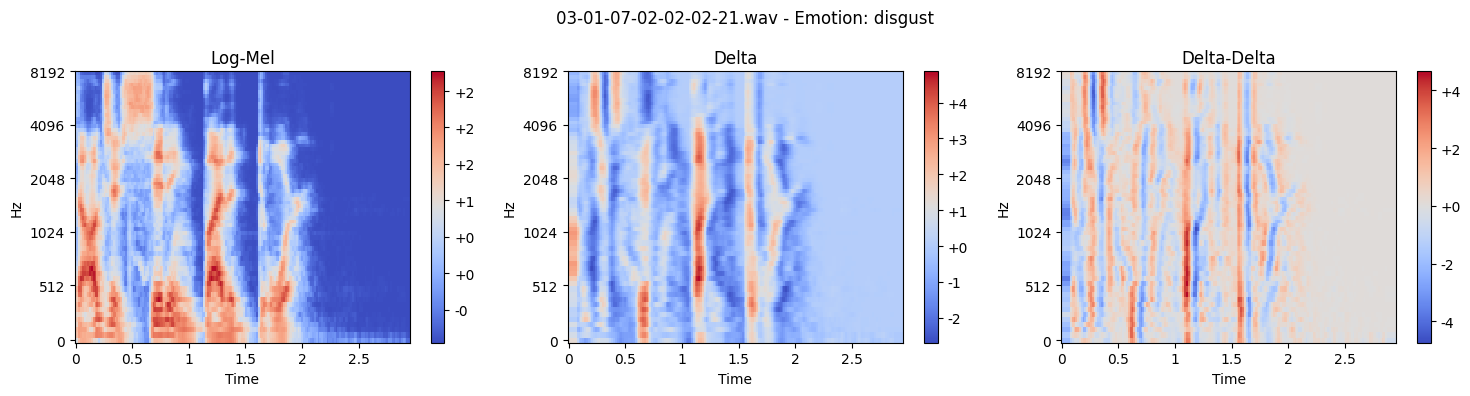

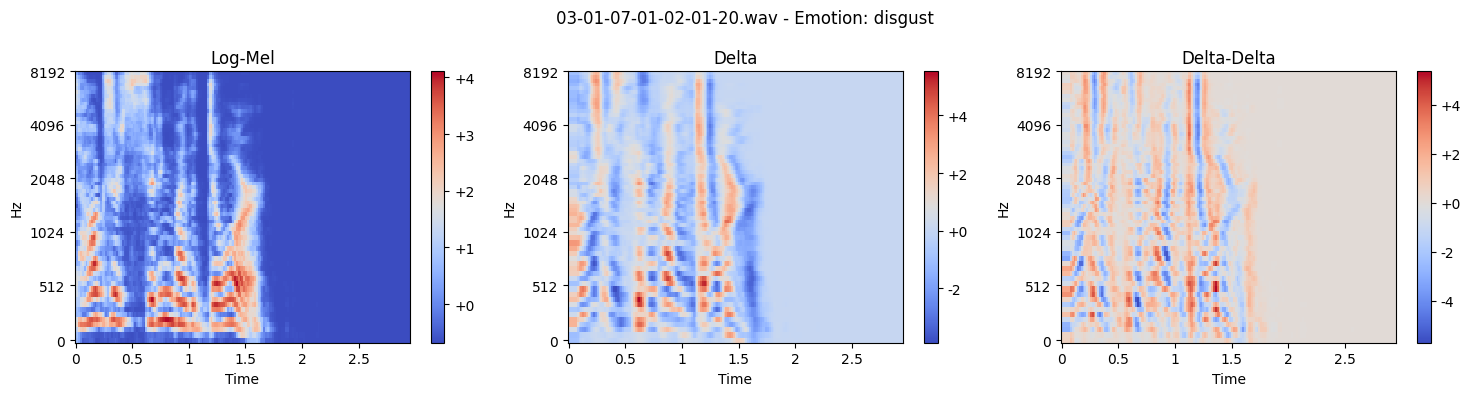

In [81]:
# Show three random log-mel spectrograms
import random
sample_files = random.sample(list(df['file_path']), 3)
for file in sample_files:
    logmel = wav_to_logmel(file)
    label = df[df['file_path'] == file]['emotion'].values[0]
    # plt.figure(figsize=(10, 4))
    # librosa.display.specshow(logmel, sr=SR, hop_length=160, x_axis='time', y_axis='mel')
    # plt.colorbar(format='%+2.0f dB')
    # plt.title(f'Log-Mel Spectrogram for {os.path.basename(file)} - Emotion: {label}')
    # plt.tight_layout()
    # plt.show()
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    titles = ['Log-Mel', 'Delta', 'Delta-Delta']
    
    for i, (ax, title) in enumerate(zip(axes, titles)):
        img = librosa.display.specshow(logmel[i], sr=SR, hop_length=HOP_LENGTH, 
                                        x_axis='time', y_axis='mel', ax=ax)
        ax.set_title(f'{title}')
        fig.colorbar(img, ax=ax, format='%+2.0f')
    
    fig.suptitle(f'{os.path.basename(file)} - Emotion: {label}')
    plt.tight_layout()
    plt.show()

In [82]:
import numpy as np
import librosa
import random

def augment_waveform_offline(y, sr):
    # Random gain
    if random.random() < 0.7:
        y = y * np.random.uniform(0.7, 1.3)

    # Add low-level noise
    if random.random() < 0.5:
        # y = y + 0.005 * np.random.randn(len(y))
        y = y + np.random.uniform(0.003, 0.01) * np.random.randn(len(y))

    # Pitch shift (±2 semitones)
    if random.random() < 0.5:
        y = librosa.effects.pitch_shift(
            y, sr=sr, n_steps=np.random.uniform(-2, 2)
        )

    # Speed perturbation
    if random.random() < 0.5:
        y = librosa.effects.time_stretch(
            y, rate=np.random.uniform(0.85, 1.15)
        )

    return y


In [83]:
def parse_actor_id(file_path):
    """Parse actor ID from filename - works for both RAVDESS and CREMA-D"""
    base_name = os.path.basename(file_path)
    
    # RAVDESS format: 03-01-06-01-02-01-12.wav (actor is last number)
    if '-' in base_name:
        actor_id = int(base_name.split('-')[-1].split('.')[0])
        return f"RAVDESS_{actor_id}"
    
    # CREMA-D format: 1001_DFA_ANG_XX.wav (actor is first number)
    elif '_' in base_name:
        actor_id = base_name.split('_')[0]
        return f"CREMA_{actor_id}"
    
    return "unknown"

# Use COMBINED dataset instead of just df
combined_df = combined_df[combined_df['emotion'] != 'unknown'].copy()
combined_df['actor_id'] = combined_df['file_path'].apply(parse_actor_id)

combined_df[["emotion", "actor_id"]].head(), combined_df["emotion"].value_counts()

(   emotion    actor_id
 0  neutral  RAVDESS_11
 1  disgust  RAVDESS_11
 2    happy  RAVDESS_11
 3  fearful  RAVDESS_11
 4    happy  RAVDESS_11,
 emotion
 disgust      1463
 happy        1463
 fearful      1463
 sad          1463
 angry        1463
 neutral      1375
 surprised     192
 Name: count, dtype: int64)

In [84]:
# Split dataset into train, validation, and test based on actor IDs

rng = np.random.default_rng(42)
all_actors = combined_df['actor_id'].unique()
rng.shuffle(all_actors)

# Calculate split sizes (proportional split)
n_actors = len(all_actors)
n_test = max(4, int(0.15 * n_actors))  # ~15% for test
n_val = max(4, int(0.15 * n_actors))   # ~15% for val
n_train = n_actors - n_test - n_val    # ~70% for train

test_actors = set(all_actors[:n_test])
val_actors = set(all_actors[n_test:n_test+n_val])
train_actors = set(all_actors[n_test+n_val:])

train_df = combined_df[combined_df['actor_id'].isin(train_actors)].copy()
test_df = combined_df[combined_df['actor_id'].isin(test_actors)].copy()
val_df = combined_df[combined_df['actor_id'].isin(val_actors)].copy()

print(f"Actors - Train: {len(train_actors)}, Val: {len(val_actors)}, Test: {len(test_actors)}")
print(f"Samples - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Actors - Train: 81, Val: 17, Test: 17
Samples - Train: 6255, Val: 1327, Test: 1300


In [85]:
# Save processed log-mel spectrograms to .npy files
import os
import numpy as np

def preprocess_and_save(df, out_dir='logmel_data', n_augment=2):
    os.makedirs(out_dir, exist_ok=True)
    new_rows = []

    for _, row in df.iterrows():
        wav_path = row['file_path']

        # Load waveform
        y, sr = librosa.load(wav_path, sr=SR)

        base_name = os.path.basename(wav_path).replace('.wav', '')

        # Original spectrogram
        logmel = wav_to_logmel(wav_path)
        out_path = os.path.join(out_dir, f'{base_name}_orig.npy')
        np.save(out_path, logmel)

        new_row = row.copy()
        new_row['spectrogram_path'] = out_path
        new_rows.append(new_row)

        # Augmented spectrograms
        for i in range(n_augment):
            y_aug = augment_waveform_offline(y, sr)
            logmel_aug = waveform_to_logmel(y_aug, sr=sr)

            out_path_aug = os.path.join(out_dir, f'{base_name}_aug{i+1}.npy')
            np.save(out_path_aug, logmel_aug)

            new_row_aug = row.copy()
            new_row_aug['spectrogram_path'] = out_path_aug
            new_rows.append(new_row_aug)

    return pd.DataFrame(new_rows)

In [86]:
# Update train and validation dataframes with spectrogram paths
# train_df = preprocess_and_save(train_df, out_dir='logmel_data/train', n_augment=2)
train_df = preprocess_and_save(train_df, out_dir='logmel_data/train', n_augment=3)
val_df = preprocess_and_save(val_df, out_dir='logmel_data/val', n_augment=0)
test_df = preprocess_and_save(test_df, out_dir='logmel_data/test', n_augment=0)

In [87]:
# Check updated dataframes and shapes
print(train_df.head())
print(val_df.head())
print(test_df.head())
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

                                    file_path emotion    actor_id  \
60  archive/Actor_21/03-01-05-02-02-02-21.wav   angry  RAVDESS_21   
60  archive/Actor_21/03-01-05-02-02-02-21.wav   angry  RAVDESS_21   
60  archive/Actor_21/03-01-05-02-02-02-21.wav   angry  RAVDESS_21   
60  archive/Actor_21/03-01-05-02-02-02-21.wav   angry  RAVDESS_21   
61  archive/Actor_21/03-01-03-01-02-01-21.wav   happy  RAVDESS_21   

                                   spectrogram_path  
60  logmel_data/train/03-01-05-02-02-02-21_orig.npy  
60  logmel_data/train/03-01-05-02-02-02-21_aug1.npy  
60  logmel_data/train/03-01-05-02-02-02-21_aug2.npy  
60  logmel_data/train/03-01-05-02-02-02-21_aug3.npy  
61  logmel_data/train/03-01-03-01-02-01-21_orig.npy  
                                     file_path    emotion    actor_id  \
240  archive/Actor_15/03-01-08-02-02-02-15.wav  surprised  RAVDESS_15   
241  archive/Actor_15/03-01-08-01-01-01-15.wav  surprised  RAVDESS_15   
242  archive/Actor_15/03-01-05-01-01-01-15

In [88]:
# Calling it above

# import os

# def parse_actor_id(file_path):
#     base_name = os.path.basename(file_path)
#     actor_id = int(base_name.split('-')[-1].split('.')[0])
#     return actor_id

# df = df[df['emotion'] != 'unknown'].copy()  # Filter out unknown emotions
# df['actor_id'] = df['file_path'].apply(parse_actor_id)

# df [["emotion", "actor_id"]].head(), df["emotion"].value_counts()

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# EMOTIONS = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
# Combined neutral and calm
EMOTIONS = ["neutral", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

class AttentionBlock(nn.Module):
    """Channel attention mechanism"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SpectrogramCNNV2(nn.Module):
    """Improved CNN with attention and residual connections"""
    def __init__(self, num_classes=len(EMOTIONS), dropout=0.5):
        super().__init__()
        
        # # Initial conv block
        # self.conv1 = nn.Sequential(
        #     nn.Conv2d(1, 32, 3, padding=1),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU(),
        #     nn.Conv2d(32, 32, 3, padding=1),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2),
        #     nn.Dropout2d(0.1),
        # )
        
        # # Second block with attention
        # self.conv2 = nn.Sequential(
        #     nn.Conv2d(32, 64, 3, padding=1),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 64, 3, padding=1),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        # )
        # self.attention2 = AttentionBlock(64)
        # self.pool2 = nn.Sequential(nn.MaxPool2d(2), nn.Dropout2d(0.2))
        
        # # Third block with attention
        # self.conv3 = nn.Sequential(
        #     nn.Conv2d(64, 128, 3, padding=1),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        #     nn.Conv2d(128, 128, 3, padding=1),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        # )
        # self.attention3 = AttentionBlock(128)
        # self.pool3 = nn.Sequential(nn.MaxPool2d(2), nn.Dropout2d(0.3))
        
        # # Fourth block 
        # self.conv4 = nn.Sequential(
        #     nn.Conv2d(128, 256, 3, padding=1),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(),
        #     nn.Conv2d(256, 256, 3, padding=1),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(),
        # )
        # self.attention4 = AttentionBlock(256)
        # self.pool4 = nn.Sequential(nn.AdaptiveAvgPool2d((2, 2)), nn.Dropout2d(0.4))
        
        # # Classifier
        # self.classifier = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(256 * 2 * 2, 256),
        #     nn.ReLU(),
        #     nn.Dropout(dropout),
        #     nn.Linear(256, 128),
        #     nn.ReLU(),
        #     nn.Dropout(dropout),
        #     nn.Linear(128, num_classes)
        # )

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),  # Added back second conv
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),  # Added back second conv
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.attention = AttentionBlock(128)
        self.pool3 = nn.Sequential(
            nn.AdaptiveAvgPool2d((2, 2)),
            nn.Dropout2d(0.3)
        )

        # Classifier - moderate size
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 2 * 2, 128),  # 512 -> 128
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.attention(x)
        x = self.pool3(x)
        x = self.classifier(x)
        return x
    # def forward(self, x):
    #     x = self.conv1(x)
        
    #     x = self.conv2(x)
    #     x = self.attention2(x)
    #     x = self.pool2(x)
        
    #     x = self.conv3(x)
    #     x = self.attention3(x)
    #     x = self.pool3(x)
        
    #     x = self.conv4(x)
    #     x = self.attention4(x)
    #     x = self.pool4(x)
        
    #     x = self.classifier(x)
    #     return x

In [90]:
# quick shape check (uses your N_MELS and TARGET_FRAMES vars if defined)
model = SpectrogramCNNV2(num_classes=len(EMOTIONS))
dummy = torch.randn(4, 1, N_MELS, TARGET_FRAMES)
logits = model(dummy)
logits.shape

torch.Size([4, 7])

In [91]:
from torch.utils.data import Dataset, DataLoader

emotion_to_idx = {emotion: idx for idx, emotion in enumerate(EMOTIONS)}
idx_to_emotion = {idx: emotion for emotion, idx in emotion_to_idx.items()}

df = df[df['emotion'].isin(EMOTIONS)].copy()  # Ensure only known emotions are included

In [92]:
import torchaudio.transforms as T

class RavdessSpectrogramDataset(Dataset):
    def __init__(self, df, emotion_to_idx, sr=SR, augment=False):
        self.df = df.reset_index(drop=True)
        self.emotion_to_idx = emotion_to_idx
        self.sr = sr
        self.augment = augment
        self.time_mask = T.TimeMasking(time_mask_param=50)
        self.freq_mask = T.FrequencyMasking(freq_mask_param=18)

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # row = self.df.iloc[idx]
        # file_path = row['file_path']
        # logmel = wav_to_logmel(file_path, sr=self.sr)
        # logmel = torch.tensor(logmel, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        # if self.augment:
        #     logmel = self.time_mask(logmel)
        #     logmel = self.freq_mask(logmel)

        # label = self.emotion_to_idx[row['emotion']]
        # return logmel, torch.tensor(label, dtype=torch.long)

        row = self.df.iloc[idx]

        logmel = np.load(row['spectrogram_path'])
        # logmel = torch.tensor(logmel, dtype=torch.float32).unsqueeze(0)
        logmel = torch.tensor(logmel, dtype=torch.float32)

        if self.augment:
            logmel = self.freq_mask(logmel)
            logmel = self.time_mask(logmel)
            
        label = self.emotion_to_idx[row['emotion']]
        return logmel, torch.tensor(label, dtype=torch.long)

In [93]:
# Split dataset into train and test based on actor IDs

# NOTE: Commented because we will do splitting before

# rng = np.random.default_rng(42)
# all_actors = df['actor_id'].unique()
# rng.shuffle(all_actors)

# test_actors = set(all_actors[:4])
# val_actors = set(all_actors[4:6])
# train_actors = set(all_actors[6:])

# train_df = df[df['actor_id'].isin(train_actors)].copy()
# test_df = df[df['actor_id'].isin(test_actors)].copy()
# val_df = df[df['actor_id'].isin(val_actors)].copy()
# len(train_df), len(test_df), len(val_df)

In [94]:
# Create datasets and dataloaders

BATCH_SIZE = 32

train_ds = RavdessSpectrogramDataset(train_df, emotion_to_idx, augment=True)
val_ds = RavdessSpectrogramDataset(val_df, emotion_to_idx, augment=False)
test_ds = RavdessSpectrogramDataset(test_df, emotion_to_idx, augment=False)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = SpectrogramCNNV2(num_classes=len(EMOTIONS), dropout=0.4).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Use class weights to handle imbalance (neutral has fewer samples)
from collections import Counter
emotion_counts = Counter(train_df['emotion'])
total = sum(emotion_counts.values())
class_weights = torch.tensor([total / (len(EMOTIONS) * emotion_counts[e]) for e in EMOTIONS], dtype=torch.float32).to(device)
print(f"Class weights: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

def mixup_data(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def run_one_epoch_train(model, loader, optimizer, criterion, device, use_mixup=False):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        # if use_mixup and random.random() < 0.3:
        #     x, y_a, y_b, lam = mixup_data(x, y, alpha=0.4)
        #     optimizer.zero_grad()
        #     logits = model(x)
        #     loss = mixup_criterion(criterion, logits, y_a, y_b, lam)
        # else:
        #     optimizer.zero_grad()
        #     logits = model(x)
        #     loss = criterion(logits, y)
        if use_mixup and random.random() < 0.2:
            x, y_a, y_b, lam = mixup_data(x, y, alpha=0.4)
            optimizer.zero_grad()
            logits = model(x)
            loss = mixup_criterion(criterion, logits, y_a, y_b, lam)
        else:
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)

        # optimizer.zero_grad()
        # logits = model(x)
        # loss = criterion(logits, y)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        correct = 0
        total = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)

    return total_loss / total, correct / total

def get_predictiion(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())
    return all_preds, all_labels

Device: cpu
Total parameters: 355,943
Class weights: tensor([0.9222, 0.8675, 0.8675, 0.8675, 0.8675, 0.8675, 6.5704])


In [96]:
# # Run train with cosine annealing and early stopping
# from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# # Cosine annealing with warm restarts works better for this task
# scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

# best_val_acc = 0.0
# best_train_acc = 0.0
# best_model_state = None
# patience_counter = 0
# PATIENCE = 15  # More patience with cosine annealing

# EPOCHS = 100

# for epoch in range(1, EPOCHS + 1):
#     train_loss, train_acc = run_one_epoch_train(model, train_dl, optimizer, criterion, device, use_mixup=False)
#     val_loss, val_acc = evaluate(model, val_dl, criterion, device)
#     scheduler.step()
    
#     current_lr = optimizer.param_groups[0]['lr']

#     # Save best model based on validation accuracy
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         best_train_acc = train_acc
#         best_model_state = model.state_dict().copy()
#         patience_counter = 0
#         marker = " *"
#     else:
#         patience_counter += 1
#         marker = ""
#         if patience_counter >= PATIENCE:
#             print("Early stopping triggered")
#             break
    
#     print(f'Epoch {epoch}/{EPOCHS} - LR: {current_lr:.2e} - '
#           f'Train Loss: {train_loss:.4f}, Train Acc: {(train_acc*100):.2f}% - '
#           f'Val Loss: {val_loss:.4f}, Val Acc: {(val_acc*100):.2f}%{marker}')

# # Load best model
# if best_model_state is not None:
#     model.load_state_dict(best_model_state)
#     print(f"\nLoaded best model with Val Acc: {best_val_acc*100:.2f}% and Train Acc: {best_train_acc*100:.2f}%")

In [97]:
# preds, labels = get_predictiion(model, test_dl, device)
# print(classification_report(labels, preds, target_names=EMOTIONS))

# cm = confusion_matrix(labels, preds)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', xticklabels=EMOTIONS, yticklabels=EMOTIONS, cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

While training, we got Train Acc 69.31% and Val Acc 63.33%

## Transfer Learning

We will see how transfer learning is working in our case.



In [98]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights, efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models import resnet34, ResNet34_Weights

class ResNet18Emotion(nn.Module):
    def __init__(self, num_classes=len(EMOTIONS), dropout=0.5, freeze_until='layer2'):
        super().__init__()
        
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Freeze early layers
        # ResNet18 layers: conv1, bn1, layer1, layer2, layer3, layer4
        if freeze_until:
            freeze = True
            for name, param in self.resnet.named_parameters():
                if freeze_until in name:
                    freeze = False
                param.requires_grad = not freeze
                    

        # Replace classifier head
        num_features = self.resnet.fc.in_features
        # self.resnet.fc = nn.Sequential(
        #     nn.Dropout(dropout),
        #     nn.Linear(num_features, num_classes)
        # )
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),  # Less dropout in second layer
            nn.Linear(128, num_classes)
        )


    def forward(self, x):
        # Input already has 3 channels (logmel, delta, delta2) - no need to repeat
        # Only repeat if input has 1 channel
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        return self.resnet(x)

In [ ]:
# freeze_until options: 'layer1', 'layer2', 'layer3', 'layer4', or None (no freezing)
#model_resnet = ResNet34Emotion(num_classes=len(EMOTIONS), dropout=0.4, freeze_until='layer2').to(device)
model_resnet = ResNet18Emotion(num_classes=len(EMOTIONS), dropout=0.4, freeze_until='layer1').to(device)

# Count parameters
total_params = sum(p.numel() for p in model_resnet.parameters())
trainable_params = sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}, Trainable: {trainable_params:,}, Frozen: {frozen_params:,}")

# Test forward pass
# dummy = torch.randn(4, 1, N_MELS, TARGET_FRAMES).to(device)
dummy = torch.randn(4, 3, N_MELS, TARGET_FRAMES).to(device)
logits = model_resnet(dummy)
print(f"Output shape: {logits.shape}")

Total parameters: 11,341,639, Trainable: 11,184,135, Frozen: 157,504
Output shape: torch.Size([4, 7])


In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.lr_scheduler import OneCycleLR

# Only optimize trainable parameters
optimizer_resnet = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model_resnet.parameters()),
    lr=5e-4,
    weight_decay=2e-3
)

criterion_resnet = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
scheduler_resnet = CosineAnnealingWarmRestarts(optimizer_resnet, T_0=10, T_mult=2, eta_min=1e-6)
# scheduler_resnet = OneCycleLR(optimizer_resnet, max_lr=1e-3, steps_per_epoch=len(train_dl), epochs=100, pct_start=0.1, anneal_strategy='cos')

In [101]:
best_val_acc = 0.0
best_train_acc = 0.0
best_model_state = None
patience_counter = 0
PATIENCE = 15
EPOCHS = 100

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_one_epoch_train(
        model_resnet, train_dl, optimizer_resnet, criterion_resnet, device, use_mixup=True
    )
    val_loss, val_acc = evaluate(model_resnet, val_dl, criterion_resnet, device)
    scheduler_resnet.step()
    
    current_lr = optimizer_resnet.param_groups[0]['lr']

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_train_acc = train_acc
        best_model_state = model_resnet.state_dict().copy()
        patience_counter = 0
        marker = " *"
    else:
        patience_counter += 1
        marker = ""
        if patience_counter >= PATIENCE:
            print("Early stopping triggered")
            break
    
    print(f'Epoch {epoch}/{EPOCHS} - LR: {current_lr:.2e} - '
          f'Train Loss: {train_loss:.4f}, Train Acc: {(train_acc*100):.2f}% - '
          f'Val Loss: {val_loss:.4f}, Val Acc: {(val_acc*100):.2f}%{marker}')

if best_model_state is not None:
    model_resnet.load_state_dict(best_model_state)
    print(f"\nBest model - Val Acc: {best_val_acc*100:.2f}%, Train Acc: {best_train_acc*100:.2f}%")

Epoch 1/100 - LR: 2.93e-04 - Train Loss: 1.9269, Train Acc: 30.35% - Val Loss: 1.8662, Val Acc: 43.18% *
Epoch 2/100 - LR: 2.71e-04 - Train Loss: 1.7981, Train Acc: 40.34% - Val Loss: 1.7867, Val Acc: 48.38% *
Epoch 3/100 - LR: 2.38e-04 - Train Loss: 1.7338, Train Acc: 44.44% - Val Loss: 1.7907, Val Acc: 50.41% *
Epoch 4/100 - LR: 1.97e-04 - Train Loss: 1.6687, Train Acc: 47.27% - Val Loss: 1.7238, Val Acc: 54.18% *
Epoch 5/100 - LR: 1.50e-04 - Train Loss: 1.6121, Train Acc: 50.95% - Val Loss: 1.7225, Val Acc: 54.41% *
Epoch 6/100 - LR: 1.04e-04 - Train Loss: 1.5450, Train Acc: 55.33% - Val Loss: 1.6818, Val Acc: 57.80% *
Epoch 7/100 - LR: 6.26e-05 - Train Loss: 1.4746, Train Acc: 58.37% - Val Loss: 1.6697, Val Acc: 59.08% *
Epoch 8/100 - LR: 2.96e-05 - Train Loss: 1.4156, Train Acc: 62.94% - Val Loss: 1.6661, Val Acc: 59.31% *
Epoch 9/100 - LR: 8.32e-06 - Train Loss: 1.3840, Train Acc: 65.22% - Val Loss: 1.6939, Val Acc: 58.85%
Epoch 10/100 - LR: 3.00e-04 - Train Loss: 1.3638, Train A

              precision    recall  f1-score   support

     neutral       0.63      0.61      0.62       203
       happy       0.62      0.53      0.57       213
         sad       0.47      0.53      0.50       213
       angry       0.68      0.72      0.70       213
     fearful       0.52      0.37      0.43       213
     disgust       0.56      0.68      0.61       213
   surprised       0.62      0.91      0.73        32

    accuracy                           0.58      1300
   macro avg       0.58      0.62      0.59      1300
weighted avg       0.58      0.58      0.58      1300



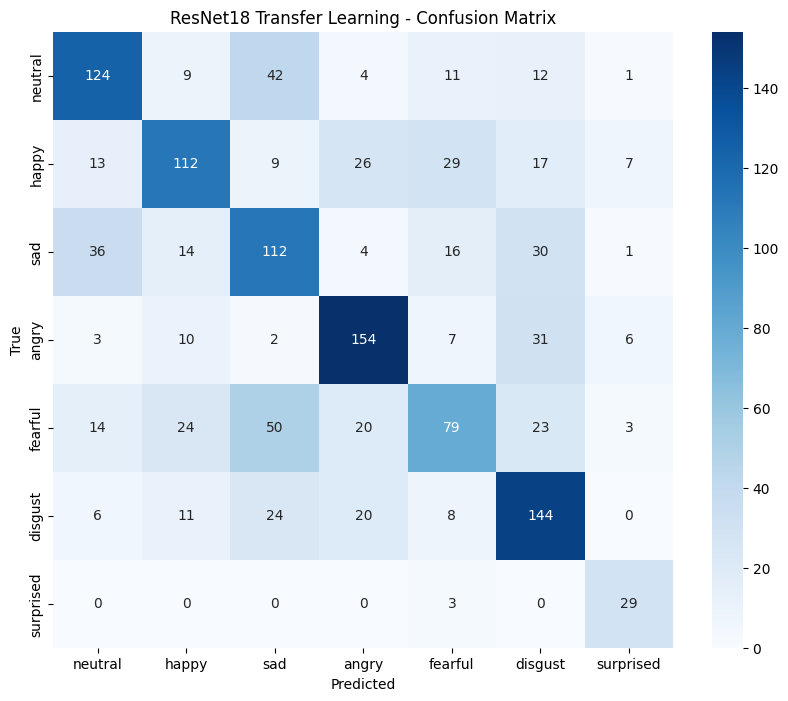

In [102]:
preds, labels = get_predictiion(model_resnet, test_dl, device)
print(classification_report(labels, preds, target_names=EMOTIONS))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=EMOTIONS, yticklabels=EMOTIONS, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ResNet18 Transfer Learning - Confusion Matrix')
plt.show()

Trying Wav2Vec2-XLSR
-------------------------------------------------------------------------------------------------------------------------

In [103]:
# from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# import librosa
# import numpy as np

# # Use same emotions as before
# EMOTIONS = ["neutral", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

# # Load pretrained Wav2Vec2-XLSR (multilingual, 53 languages)
# # MODEL_NAME = "facebook/wav2vec2-large-xlsr-53"
# # Alternative smaller model if memory is an issue:
# MODEL_NAME = "facebook/wav2vec2-base"

# feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_NAME)

In [104]:
# class Wav2Vec2EmotionModel(nn.Module):
#     def __init__(self, model_name, num_labels, dropout=0.3):
#         super().__init__()
#         self.wav2vec2 = Wav2Vec2ForSequenceClassification.from_pretrained(
#             model_name,
#             num_labels=num_labels,
#             problem_type="single_label_classification"
#         )
#         # Freeze the feature extractor (CNN layers)
#         self.wav2vec2.freeze_feature_encoder()
        
#         # Optionally freeze some transformer layers for less overfitting
#         # Freeze first 12 transformer layers (out of 24), keep last 12 trainable
#         for name, param in self.wav2vec2.named_parameters():
#             if "wav2vec2.encoder.layers" in name:
#                 layer_num = int(name.split("encoder.layers.")[1].split(".")[0])
#                 if layer_num < 12:  # Freeze first 12 layers
#                     param.requires_grad = False
    
#     def forward(self, input_values, attention_mask=None):
#         outputs = self.wav2vec2(input_values=input_values, attention_mask=attention_mask)
#         return outputs.logits

In [105]:
# class Wav2Vec2Dataset(Dataset):
#     """Dataset that loads raw audio for Wav2Vec2"""
#     def __init__(self, df, emotion_to_idx, sr=16000, max_duration=3.0, start=1.0):
#         self.df = df.reset_index(drop=True)
#         self.emotion_to_idx = emotion_to_idx
#         self.sr = sr
#         self.max_samples = int(sr * max_duration)
#         self.start_sample = int(sr * start)
        
#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
#         file_path = row['file_path']
        
#         # Load audio
#         y, _ = librosa.load(file_path, sr=self.sr, mono=True)
        
#         # Trim from start, then take max_duration
#         y = y[self.start_sample:] if len(y) > self.start_sample else np.array([])
        
#         if len(y) >= self.max_samples:
#             y = y[:self.max_samples]
#         else:
#             y = np.pad(y, (0, self.max_samples - len(y)), "constant")
        
#         # Process with feature extractor
#         inputs = feature_extractor(
#             y, 
#             sampling_rate=self.sr, 
#             return_tensors="pt",
#             padding=False
#         )
#         input_values = inputs.input_values.squeeze(0)
        
#         label = self.emotion_to_idx[row['emotion']]
#         return input_values, torch.tensor(label, dtype=torch.long)


# def collate_fn(batch):
#     """Collate function to handle variable length audio"""
#     input_values = [item[0] for item in batch]
#     labels = torch.stack([item[1] for item in batch])
    
#     # Pad sequences to same length
#     input_values = torch.nn.utils.rnn.pad_sequence(
#         input_values, batch_first=True, padding_value=0.0
#     )
    
#     # Create attention mask (1 for real values, 0 for padding)
#     attention_mask = (input_values != 0).long()
    
#     return input_values, attention_mask, labels

In [106]:
# # Create Wav2Vec2 datasets using ORIGINAL dataframes (not augmented spectrograms)
# # We need to reload original splits since wav2vec uses raw audio

# # Reload original data
# df_wav2vec = load_dataset('archive')
# df_wav2vec['emotion'] = df_wav2vec['emotion'].replace({'calm': 'neutral'})
# df_wav2vec = df_wav2vec[df_wav2vec['emotion'] != 'unknown'].copy()
# df_wav2vec['actor_id'] = df_wav2vec['file_path'].apply(parse_actor_id)
# df_wav2vec = df_wav2vec[df_wav2vec['emotion'].isin(EMOTIONS)].copy()

# # Same actor split as before
# rng = np.random.default_rng(42)
# all_actors = df_wav2vec['actor_id'].unique()
# rng.shuffle(all_actors)

# test_actors_w2v = set(all_actors[:4])
# val_actors_w2v = set(all_actors[4:8])
# train_actors_w2v = set(all_actors[8:])

# train_df_w2v = df_wav2vec[df_wav2vec['actor_id'].isin(train_actors_w2v)].copy()
# val_df_w2v = df_wav2vec[df_wav2vec['actor_id'].isin(val_actors_w2v)].copy()
# test_df_w2v = df_wav2vec[df_wav2vec['actor_id'].isin(test_actors_w2v)].copy()

# print(f"Wav2Vec2 splits - Train: {len(train_df_w2v)}, Val: {len(val_df_w2v)}, Test: {len(test_df_w2v)}")

In [107]:
# # Create dataloaders
# BATCH_SIZE_W2V = 8  # Smaller batch size due to memory requirements

# train_ds_w2v = Wav2Vec2Dataset(train_df_w2v, emotion_to_idx)
# val_ds_w2v = Wav2Vec2Dataset(val_df_w2v, emotion_to_idx)
# test_ds_w2v = Wav2Vec2Dataset(test_df_w2v, emotion_to_idx)

# train_dl_w2v = DataLoader(train_ds_w2v, batch_size=BATCH_SIZE_W2V, shuffle=True, 
#                           collate_fn=collate_fn, num_workers=2)
# val_dl_w2v = DataLoader(val_ds_w2v, batch_size=BATCH_SIZE_W2V, shuffle=False, 
#                         collate_fn=collate_fn)
# test_dl_w2v = DataLoader(test_ds_w2v, batch_size=BATCH_SIZE_W2V, shuffle=False, 
#                          collate_fn=collate_fn)

In [108]:
# # Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Wav2Vec2 Device: {device}")

# model_w2v = Wav2Vec2EmotionModel(MODEL_NAME, num_labels=len(EMOTIONS), dropout=0.3).to(device)

# # Count parameters
# total_params = sum(p.numel() for p in model_w2v.parameters())
# trainable_params = sum(p.numel() for p in model_w2v.parameters() if p.requires_grad)
# print(f"Total: {total_params:,}, Trainable: {trainable_params:,}, Frozen: {total_params - trainable_params:,}")

In [109]:
# # Wav2Vec2 training functions
# def train_epoch_w2v(model, loader, optimizer, criterion, device):
#     model.train()
#     total_loss, correct, total = 0.0, 0, 0
    
#     for input_values, attention_mask, labels in loader:
#         input_values = input_values.to(device)
#         attention_mask = attention_mask.to(device)
#         labels = labels.to(device)
        
#         optimizer.zero_grad()
#         logits = model(input_values, attention_mask)
#         loss = criterion(logits, labels)
#         loss.backward()
        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
        
#         total_loss += loss.item() * labels.size(0)
#         preds = logits.argmax(dim=1)
#         correct += (preds == labels).sum().item()
#         total += labels.size(0)
    
#     return total_loss / total, correct / total


# def eval_epoch_w2v(model, loader, criterion, device):
#     model.eval()
#     total_loss, correct, total = 0.0, 0, 0
    
#     with torch.no_grad():
#         for input_values, attention_mask, labels in loader:
#             input_values = input_values.to(device)
#             attention_mask = attention_mask.to(device)
#             labels = labels.to(device)
            
#             logits = model(input_values, attention_mask)
#             loss = criterion(logits, labels)
            
#             total_loss += loss.item() * labels.size(0)
#             preds = logits.argmax(dim=1)
#             correct += (preds == labels).sum().item()
#             total += labels.size(0)
    
#     return total_loss / total, correct / total


# def get_predictions_w2v(model, loader, device):
#     model.eval()
#     all_preds, all_labels = [], []
    
#     with torch.no_grad():
#         for input_values, attention_mask, labels in loader:
#             input_values = input_values.to(device)
#             attention_mask = attention_mask.to(device)
            
#             logits = model(input_values, attention_mask)
#             preds = logits.argmax(dim=1).cpu().numpy()
#             all_preds.extend(preds)
#             all_labels.extend(labels.numpy())
    
#     return all_preds, all_labels

In [110]:
# # Setup optimizer and scheduler for Wav2Vec2
# from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# optimizer_w2v = torch.optim.AdamW(
#     filter(lambda p: p.requires_grad, model_w2v.parameters()),
#     lr=1e-5,  # Lower LR for pretrained transformer
#     weight_decay=1e-2
# )

# # Recompute class weights for original (non-augmented) data
# from collections import Counter
# emotion_counts_w2v = Counter(train_df_w2v['emotion'])
# total_w2v = sum(emotion_counts_w2v.values())
# class_weights_w2v = torch.tensor(
#     [total_w2v / (len(EMOTIONS) * emotion_counts_w2v[e]) for e in EMOTIONS], 
#     dtype=torch.float32
# ).to(device)

# criterion_w2v = nn.CrossEntropyLoss(weight=class_weights_w2v, label_smoothing=0.1)
# scheduler_w2v = CosineAnnealingWarmRestarts(optimizer_w2v, T_0=5, T_mult=2, eta_min=1e-7)

In [111]:
# # Train Wav2Vec2 model
# best_val_acc_w2v = 0.0
# best_train_acc_w2v = 0.0
# best_model_state_w2v = None
# patience_counter = 0
# PATIENCE = 10
# EPOCHS = 50  # Fewer epochs needed for pretrained model

# print("Starting Wav2Vec2-XLSR training...")
# print("-" * 60)

# for epoch in range(1, EPOCHS + 1):
#     train_loss, train_acc = train_epoch_w2v(
#         model_w2v, train_dl_w2v, optimizer_w2v, criterion_w2v, device
#     )
#     val_loss, val_acc = eval_epoch_w2v(model_w2v, val_dl_w2v, criterion_w2v, device)
#     scheduler_w2v.step()
    
#     current_lr = optimizer_w2v.param_groups[0]['lr']

#     if val_acc > best_val_acc_w2v:
#         best_val_acc_w2v = val_acc
#         best_train_acc_w2v = train_acc
#         best_model_state_w2v = model_w2v.state_dict().copy()
#         patience_counter = 0
#         marker = " *"
#     else:
#         patience_counter += 1
#         marker = ""
#         if patience_counter >= PATIENCE:
#             print("Early stopping triggered")
#             break
    
#     print(f'Epoch {epoch}/{EPOCHS} - LR: {current_lr:.2e} - '
#           f'Train Loss: {train_loss:.4f}, Train Acc: {(train_acc*100):.2f}% - '
#           f'Val Loss: {val_loss:.4f}, Val Acc: {(val_acc*100):.2f}%{marker}')

# if best_model_state_w2v is not None:
#     model_w2v.load_state_dict(best_model_state_w2v)
#     print(f"\n🎯 Wav2Vec2 Best - Val Acc: {best_val_acc_w2v*100:.2f}%, Train Acc: {best_train_acc_w2v*100:.2f}%")

In [112]:
# # Evaluate on test set
# preds_w2v, labels_w2v = get_predictions_w2v(model_w2v, test_dl_w2v, device)
# print(classification_report(labels_w2v, preds_w2v, target_names=EMOTIONS))

# cm_w2v = confusion_matrix(labels_w2v, preds_w2v)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_w2v, annot=True, fmt='d', xticklabels=EMOTIONS, yticklabels=EMOTIONS, cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Wav2Vec2-XLSR - Confusion Matrix')
# plt.show()